In [2]:
import pygame
import sys
import os
import random
import gym
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import mpr_training_env
from mpr_training_env import Env
import matplotlib.pyplot as plt

TEST 1 

POSITION FIXE : 

player : (11344, 5780)
checkpoint : (4482, 7259)



- Model = 256,64
- C = 50 
- action = (3,3)
- batch size = 64
- temps d'execution = 15 min 



In [ ]:
def build_model(input_shape, action_space):
    model = nn.Sequential(
        nn.Linear(input_shape, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),  # Couche supplémentaire ajoutée
        nn.ReLU(),            # Activation ajoutée pour la couche supplémentaire
        nn.Linear(128, 64),   # Modification des dimensions de sortie de la couche précédente
        nn.ReLU(),
        nn.Linear(64, action_space)
    )
    return model

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95   
        self.epsilon = 1.0  
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.955
        self.model = build_model(state_size, action_size)
        self.target_model = build_model(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if torch.rand(1) <= self.epsilon:
            return torch.randint(0, self.action_size, (1,)).item()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def replay(self, batch_size,verbose = False):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, targets = [], []
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32)

            target = self.model(state_tensor)
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * torch.max(self.target_model(next_state_tensor))

            states.append(state)
            targets.append(target)

        states_tensor = torch.tensor(states, dtype=torch.float32)
        targets_tensor = torch.stack(targets)
        
        self.optimizer.zero_grad()
        outputs = self.model(states_tensor)
        loss = self.loss_fn(outputs, targets_tensor)
        loss.backward()
        self.optimizer.step()
        


        if(verbose) : 
            print(f"Loss: {loss.item()}")
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())




#ENTRAINEMENT
    
env = Env(None,(9,9))

state_size = 4
action_size = env.nb_actions
batch_size = 64
n_episodes = 20
C = 30  # Fréquence de mise à jour du réseau cible

train_loss = []

agent = DQNAgent(state_size, action_size)

for episode in range(n_episodes):
    state = env.reset()
    print("Position du player :",env.player_pos)
    print("Position du checkpoint :",env.checkpoint_pos)
 
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        #print("action",action)
        next_state, reward, done = env.step(action)
        #print("reward = ",reward)
        #print(f"next state : {next_state}, reward : {reward}, done : {done}")
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            agent.update_target_model()
            print(f"Episode: {episode+1}/{n_episodes}, score: {total_reward}, e: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            loss = agent.replay(batch_size)

        if episode % C == 0:
            agent.update_target_model()

    train_loss.append(loss)



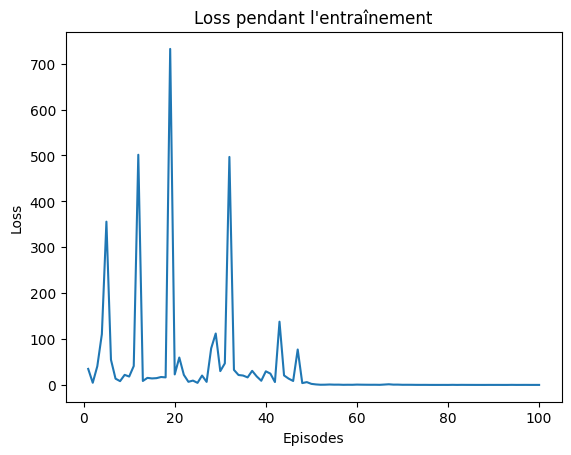



TEST 2 : 
-  POSITION FIXE : 
player : (4482, 7259)
checkpoint : (11344, 5780)

Parametres :
- model (256,64)
- action = (3,3)
- C = 50 
- batch_size = 64 


In [ ]:
#AGENT DQN 


def build_model(input_shape, action_space):
    model = nn.Sequential(
        nn.Linear(input_shape, 256),  # Réduction de la taille de cette couche
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, action_space)
    )
    return model


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95   
        self.epsilon = 1.0  
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.955
        self.model = build_model(state_size, action_size)
        self.target_model = build_model(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if torch.rand(1) <= self.epsilon:
            return torch.randint(0, self.action_size, (1,)).item()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def replay(self, batch_size,verbose = False):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, targets = [], []
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32)

            target = self.model(state_tensor)
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * torch.max(self.target_model(next_state_tensor))

            states.append(state)
            targets.append(target)

        states_tensor = torch.tensor(states, dtype=torch.float32)
        targets_tensor = torch.stack(targets)
        
        self.optimizer.zero_grad()
        outputs = self.model(states_tensor)
        loss = self.loss_fn(outputs, targets_tensor)
        loss.backward()
        self.optimizer.step()



        if(verbose) : 
            print(f"Loss: {loss.item()}")
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())




#ENTRAINEMENT
    
env = Env(None,(3,3))

state_size = 4
action_size = env.nb_actions
batch_size = 64
n_episodes = 100
C = 50  # Fréquence de mise à jour du réseau cible

train_loss = []
train_total_reward = []

agent = DQNAgent(state_size, action_size)

for episode in range(n_episodes):
    state = env.reset()
    print("Position du player :",env.player_pos)
    print("Position du checkpoint :",env.checkpoint_pos)
 
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        #print("action",action)
        next_state, reward, done = env.step(action)
        #print("reward = ",reward)
        #print(f"next state : {next_state}, reward : {reward}, done : {done}")
        agent.remember(state, action, reward, next_state, done)
        print("Score: {:.15f}".format(reward))
        state = next_state
        total_reward += reward
        if done:
            agent.update_target_model()
            print(f"Episode: {episode+1}/{n_episodes}, total_reward: {total_reward:.6f}, e: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            loss = agent.replay(batch_size)

        if episode % C == 0:
            agent.update_target_model()

    train_loss.append(loss)
    train_total_reward.append(total_reward)

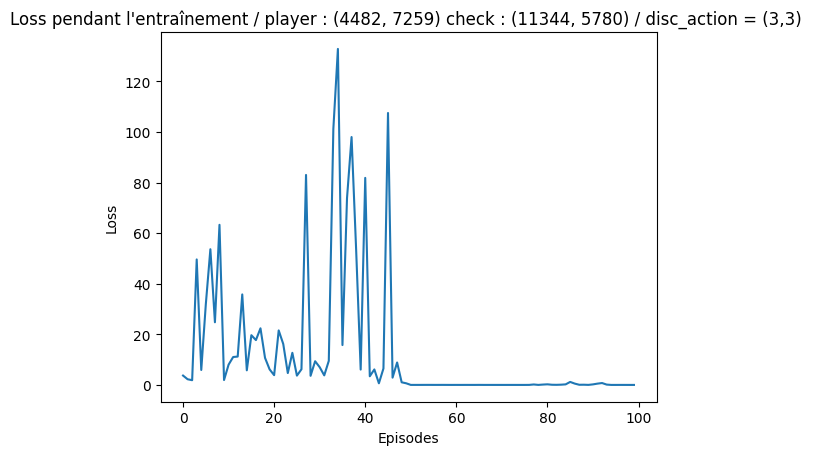

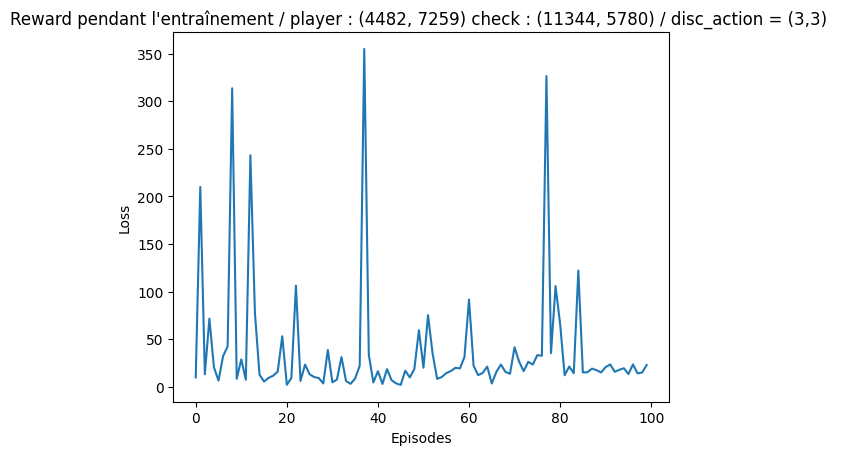

TEST 3

POSITION ALEATOIRE


Parametres : 

Parametres :
- model (256,64)
- action = (3,3)
- C = 50 
- batch_size = 64 


In [ ]:
#AGENT DQN 


def build_model(input_shape, action_space):
    model = nn.Sequential(
        nn.Linear(input_shape, 256),  # Réduction de la taille de cette couche
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, action_space)
    )
    return model


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95   
        self.epsilon = 1.0  
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.955
        self.model = build_model(state_size, action_size)
        self.target_model = build_model(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if torch.rand(1) <= self.epsilon:
            return torch.randint(0, self.action_size, (1,)).item()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def replay(self, batch_size,verbose = False):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, targets = [], []
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32)

            target = self.model(state_tensor)
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * torch.max(self.target_model(next_state_tensor))

            states.append(state)
            targets.append(target)

        states_tensor = torch.tensor(states, dtype=torch.float32)
        targets_tensor = torch.stack(targets)
        
        self.optimizer.zero_grad()
        outputs = self.model(states_tensor)
        loss = self.loss_fn(outputs, targets_tensor)
        loss.backward()
        self.optimizer.step()



        if(verbose) : 
            print(f"Loss: {loss.item()}")
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())




#ENTRAINEMENT
    
env = Env(None,(3,3))

state_size = 4
action_size = env.nb_actions
batch_size = 64
n_episodes = 100
C = 50  # Fréquence de mise à jour du réseau cible

train_loss = []
train_total_reward = []

agent = DQNAgent(state_size, action_size)

for episode in range(n_episodes):
    state = env.reset()
    print("Position du player :",env.player_pos)
    print("Position du checkpoint :",env.checkpoint_pos)
 
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        #print("action",action)
        next_state, reward, done = env.step(action)
        #print("reward = ",reward)
        #print(f"next state : {next_state}, reward : {reward}, done : {done}")
        agent.remember(state, action, reward, next_state, done)
        print("Score: {:.15f}".format(reward))
        state = next_state
        total_reward += reward
        if done:
            agent.update_target_model()
            print(f"Episode: {episode+1}/{n_episodes}, total_reward: {total_reward:.6f}, e: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            loss = agent.replay(batch_size)

        if episode % C == 0:
            agent.update_target_model()

    train_loss.append(loss)
    train_total_reward.append(total_reward)

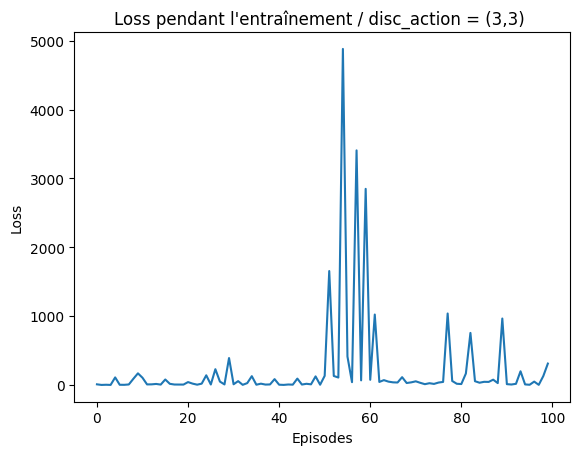
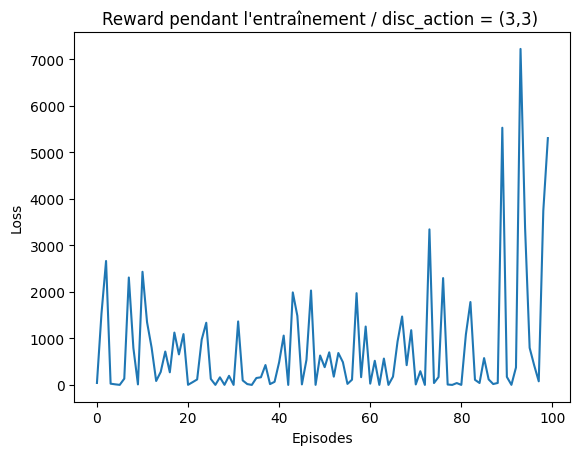

TEST 4 

POSITION ALEATOIRE

Parametres :
- model 5(512,256)
- action = (9,9)
- C = 50 
- batch_size = 64 


In [ ]:
#AGENT DQN 


def build_model(input_shape, action_space):
    model = nn.Sequential(
        nn.Linear(input_shape, 512),  # Réduction de la taille de cette couche
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256,action_space)
    )
    return model


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95   
        self.epsilon = 1.0  
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.955
        self.model = build_model(state_size, action_size)
        self.target_model = build_model(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if torch.rand(1) <= self.epsilon:
            return torch.randint(0, self.action_size, (1,)).item()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def replay(self, batch_size,verbose = False):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, targets = [], []
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32)

            target = self.model(state_tensor)
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * torch.max(self.target_model(next_state_tensor))

            states.append(state)
            targets.append(target)

        states_tensor = torch.tensor(states, dtype=torch.float32)
        targets_tensor = torch.stack(targets)
        
        self.optimizer.zero_grad()
        outputs = self.model(states_tensor)
        loss = self.loss_fn(outputs, targets_tensor)
        loss.backward()
        self.optimizer.step()



        if(verbose) : 
            print(f"Loss: {loss.item()}")
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())


#ENTRAINEMENT
    
env = Env(None,(9,9))

state_size = 4
action_size = env.nb_actions
batch_size = 64
n_episodes = 100
C = 50  # Fréquence de mise à jour du réseau cible

train_loss = []
train_total_reward = []

agent = DQNAgent(state_size, action_size)

for episode in range(n_episodes):
    state = env.reset()
    print("Position du player :",env.player_pos)
    print("Position du checkpoint :",env.checkpoint_pos)
 
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        #print("action",action)
        next_state, reward, done = env.step(action)
        #print("reward = ",reward)
        #print(f"next state : {next_state}, reward : {reward}, done : {done}")
        agent.remember(state, action, reward, next_state, done)
        print("Score: {:.15f}".format(reward))
        state = next_state
        total_reward += reward
        if done:
            agent.update_target_model()
            print(f"Episode: {episode+1}/{n_episodes}, total_reward: {total_reward:.6f}, e: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            loss = agent.replay(batch_size)

        if episode % C == 0:
            agent.update_target_model()

    train_loss.append(loss)
    train_total_reward.append(total_reward)

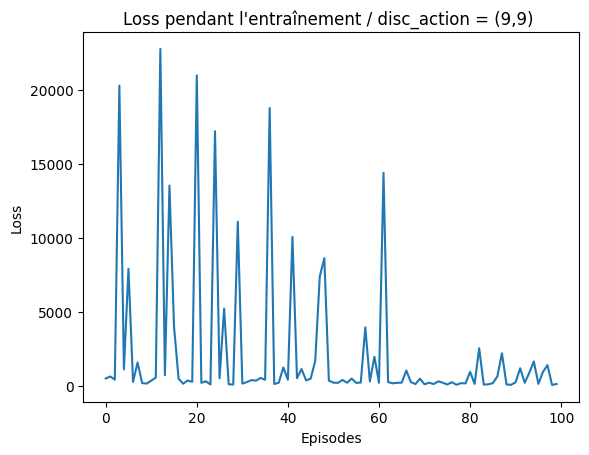
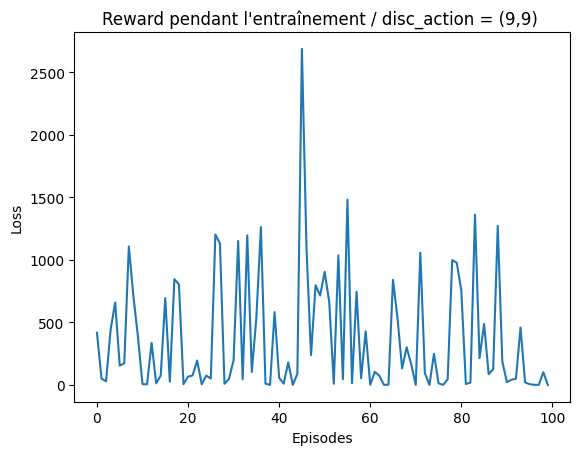

TEST 5

POSITION FIXE :

player : (6627, 4287)
checkpoint : (13308, 6553)


Parametres :
- model = (512, 256)
- action = (3,3)
- C = 50 
- batch_size = 64 


In [ ]:
#AGENT DQN 

def build_model(input_shape, action_space):
    model = nn.Sequential(
        nn.Linear(input_shape, 512),  # Réduction de la taille de cette couche
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256,action_space)
    )
    return model


class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95   
        self.epsilon = 1.0  
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.955
        self.model = build_model(state_size, action_size)
        self.target_model = build_model(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.MSELoss()


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if torch.rand(1) <= self.epsilon:
            return torch.randint(0, self.action_size, (1,)).item()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def replay(self, batch_size,verbose = False):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, targets = [], []
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32)

            target = self.model(state_tensor)
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * torch.max(self.target_model(next_state_tensor))

            states.append(state)
            targets.append(target)

        states_tensor = torch.tensor(states, dtype=torch.float32)
        targets_tensor = torch.stack(targets)
        
        self.optimizer.zero_grad()
        outputs = self.model(states_tensor)
        loss = self.loss_fn(outputs, targets_tensor)
        loss.backward()
        self.optimizer.step()



        if(verbose) : 
            print(f"Loss: {loss.item()}")
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())


#ENTRAINEMENT
    
env = Env(None,(3,3))

state_size = 4
action_size = env.nb_actions
batch_size = 64
n_episodes = 100
C = 50  # Fréquence de mise à jour du réseau cible

train_loss = []
train_total_reward = []

agent = DQNAgent(state_size, action_size)

for episode in range(n_episodes):
    state = env.reset()
    print("Position du player :",env.player_pos)
    print("Position du checkpoint :",env.checkpoint_pos)
 
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        #print("action",action)
        next_state, reward, done = env.step(action)
        #print("reward = ",reward)
        #print(f"next state : {next_state}, reward : {reward}, done : {done}")
        agent.remember(state, action, reward, next_state, done)
        print("Score: {:.15f}".format(reward))
        state = next_state
        total_reward += reward
        if done:
            agent.update_target_model()
            print(f"Episode: {episode+1}/{n_episodes}, total_reward: {total_reward:.6f}, e: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            loss = agent.replay(batch_size)

        if episode % C == 0:
            agent.update_target_model()

    train_loss.append(loss)
    train_total_reward.append(total_reward)

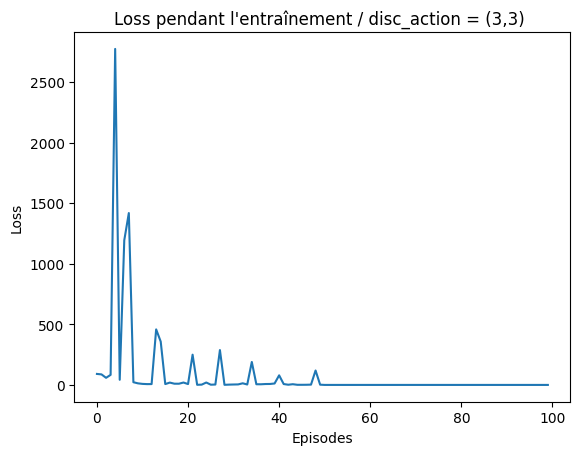
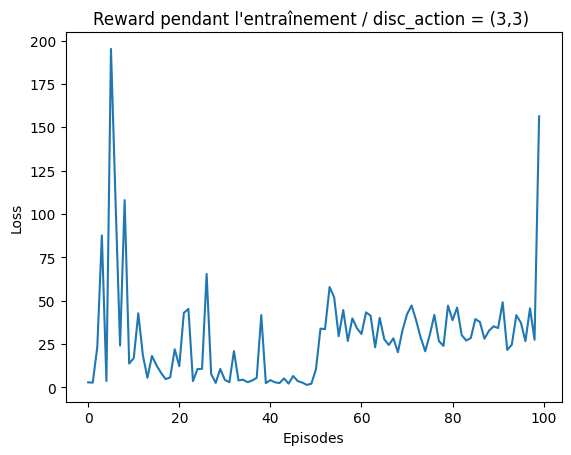

TEST 6

POSITION ALEATOIRE 


Parametres :

model =  
    512,256  / 
     lr = 0.00005 /
     epsilon_min = 0.1

- action = (3,3)
- C = 50 
- batch_size = 64 



In [ ]:
#AGENT DQN 

def build_model(input_shape, action_space):
    model = nn.Sequential(
        nn.Linear(input_shape, 512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,action_size))
    return model

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=100000)
        self.gamma = 0.99  # discount rate
        self.epsilon = 0.9  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.99
        self.model = build_model(state_size, action_size)
        self.target_model = build_model(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(),  lr=0.00005)
        self.loss_fn = nn.MSELoss()


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if torch.rand(1) <= self.epsilon:
            return torch.randint(0, self.action_size, (1,)).item()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()

    def replay(self, batch_size,verbose = False):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, targets = [], []
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.tensor(state, dtype=torch.float32)
            next_state_tensor = torch.tensor(next_state, dtype=torch.float32)

            target = self.model(state_tensor)
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * torch.max(self.target_model(next_state_tensor))

            states.append(state)
            targets.append(target)

        states_tensor = torch.tensor(states, dtype=torch.float32)
        targets_tensor = torch.stack(targets)
        
        self.optimizer.zero_grad()
        outputs = self.model(states_tensor)
        loss = self.loss_fn(outputs, targets_tensor)
        loss.backward()
        self.optimizer.step()



        if(verbose) : 
            print(f"Loss: {loss.item()}")
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())


#ENTRAINEMENT
    
env = Env(None,(3,3))

state_size = 4
action_size = env.nb_actions
batch_size = 64
n_episodes = 100
C = 50  # Fréquence de mise à jour du réseau cible

train_loss = []
train_total_reward = []

agent = DQNAgent(state_size, action_size)

for episode in range(n_episodes):
    state = env.reset()
    print("Position du player :",env.player_pos)
    print("Position du checkpoint :",env.checkpoint_pos)
 
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        #print("action",action)
        next_state, reward, done = env.step(action)
        #print("reward = ",reward)
        #print(f"next state : {next_state}, reward : {reward}, done : {done}")
        agent.remember(state, action, reward, next_state, done)
        print("Score: {:.15f}".format(reward))
        state = next_state
        total_reward += reward
        if done:
            agent.update_target_model()
            print(f"Episode: {episode+1}/{n_episodes}, total_reward: {total_reward:.6f}, e: {agent.epsilon:.2}")
            break
        if len(agent.memory) > batch_size:
            loss = agent.replay(batch_size)

        if episode % C == 0:
            agent.update_target_model()

    train_loss.append(loss)
    train_total_reward.append(total_reward)

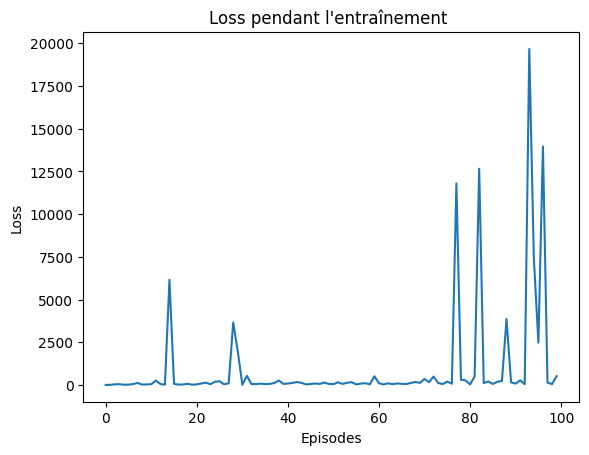
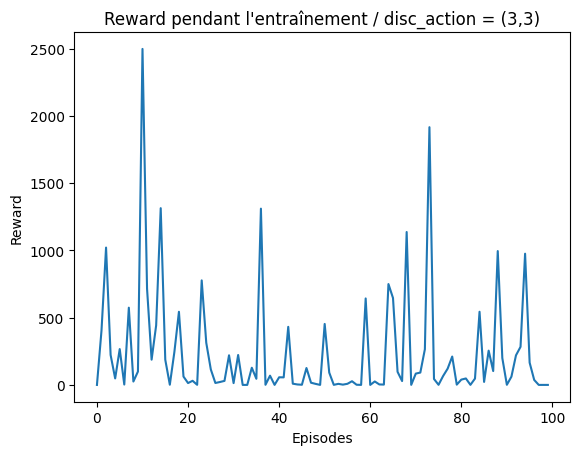